# 批量规范化

批量规范化（Batch Normalization，简称BN）是深度学习中一种重要的技术，主要用于加速神经网络的训练过程并提高模型的性能。它由Sergey Ioffe和Christian Szegedy在2015年提出，现已成为深度学习模型中的标准组件之一。

## 1. 批量规范化的动机
在深度神经网络中，随着网络层数的增加，每一层的输入分布会发生变化，这种现象称为**内部协变量偏移（Internal Covariate Shift）**。这种分布的变化会导致训练过程变得不稳定，尤其是需要更小的学习率和更精细的参数初始化。批量规范化的提出就是为了解决这一问题。

## 2. 批量规范化的原理
批量规范化通过对每一层的输入进行标准化处理，使得输入的均值和方差保持稳定。具体来说，对于每个小批量数据（mini-batch），BN会对数据进行如下操作：

1. **计算均值和方差**：
   对于每个小批量数据，计算其均值和方差：
   $$
   \mu_B = \frac{1}{m} \sum_{i=1}^m x_i
   $$
   $$
   \sigma_B^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2
   $$
   其中，$m$ 是小批量的大小，$x_i$ 是第 $i$ 个样本。

2. **标准化**：
   使用计算得到的均值和方差对数据进行标准化：
   $$
   \hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
   $$
   其中，$\epsilon$ 是一个很小的常数，用于防止除零错误。

3. **缩放和平移**：
   为了保留网络的表达能力，BN引入了两个可学习的参数 $\gamma$ 和 $\beta$，对标准化后的数据进行缩放和平移：
   $$
   y_i = \gamma \hat{x}_i + \beta
   $$
   其中，$\gamma$ 和 $\beta$ 是通过反向传播学习的参数。

## 3. 批量规范化的优点
- **加速训练**：BN可以减少内部协变量偏移，使得网络可以使用更大的学习率，从而加速训练过程。
- **提高模型性能**：BN具有一定的正则化效果，可以减少过拟合，提高模型的泛化能力。
- **减少对初始化的依赖**：BN使得网络对参数初始化的敏感性降低，使得训练更加稳定。

## 4. 批量规范化的注意事项
- **小批量大小**：BN的效果依赖于小批量数据的统计特性，因此在小批量大小较小时，BN的效果可能会变差。
- **推理阶段的处理**：在推理阶段，BN使用的是训练过程中计算的移动平均均值和方差，而不是小批量的统计量。

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        # 断言检查输入X的维度是否为2（全连接层）或4（卷积层）
        assert len(X.shape) in (2, 4)
        
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)  # 沿着第0维（批量维）计算均值
            var = ((X - mean) ** 2).mean(dim=0)  # 沿着第0维计算方差
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)  # 沿着批量、高度、宽度维计算均值，保持维度
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)  # 沿着批量、高度、宽度维计算方差，保持维度
        
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    
    # 对标准化后的数据进行缩放和平移
    Y = gamma * X_hat + beta  # 缩放和移位
    
    # 返回标准化后的数据、更新后的移动平均均值和方差
    return Y, moving_mean.data, moving_var.data

In [6]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        # 断言检查输入X的维度是否为2（全连接层）或4（卷积层）
        assert len(X.shape) in (2, 4)
        
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)  # 沿着第0维（批量维）计算均值
            var = ((X - mean) ** 2).mean(dim=0)  # 沿着第0维计算方差
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)  # 沿着批量、高度、宽度维计算均值，保持维度
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)  # 沿着批量、高度、宽度维计算方差，保持维度
        
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    
    # 对标准化后的数据进行缩放和平移
    Y = gamma * X_hat + beta  # 缩放和移位
    
    # 返回标准化后的数据、更新后的移动平均均值和方差
    return Y, moving_mean.data, moving_var.data

我们现在可以创建一个正确的BatchNorm层。这个层将保持适当的参数：拉伸gamma和偏移beta,这两个参数将
在训练过程中更新。此外，我们的层将保存均值和方差的移动平均值，以便在模型预测期间随后使用。

In [8]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        
        # 根据输入数据的维度（全连接层或卷积层）初始化形状
        if num_dims == 2:
            shape = (1, num_features)  # 全连接层：(1, num_features)
        else:
            shape = (1, num_features, 1, 1)  # 卷积层：(1, num_features, 1, 1)
        
        # 初始化可学习的参数 gamma 和 beta
        # gamma：缩放参数，初始化为全1
        # beta：平移参数，初始化为全0
        self.gamma = nn.Parameter(torch.ones(shape))  # 可学习参数，用于缩放
        self.beta = nn.Parameter(torch.zeros(shape))  # 可学习参数，用于平移
        
        # 初始化非模型参数的变量 moving_mean 和 moving_var
        # moving_mean：移动平均均值，初始化为全0
        # moving_var：移动平均方差，初始化为全1
        self.moving_mean = torch.zeros(shape)  # 非模型参数，用于推理阶段
        self.moving_var = torch.ones(shape)    # 非模型参数，用于推理阶段

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var复制到X所在的设备（如GPU）上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        
        # 调用 batch_norm 函数进行批量规范化
        # 输入参数：
        # - X：输入数据
        # - self.gamma：缩放参数
        # - self.beta：平移参数
        # - self.moving_mean：移动平均均值
        # - self.moving_var：移动平均方差
        # - eps：防止除零错误的小常数
        # - momentum：更新移动平均的动量参数
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        
        # 返回批量规范化后的输出 Y
        return Y

In [9]:
net = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
        nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
        nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
        nn.Linear(84, 10))

和以前一样，我们将在Fashion‐MNIST数据集上训练网络。这个代码与我们第一次训练LeNet时几
乎完全相同，主要区别在于学习率大得多。

loss 0.268, train acc 0.900, test acc 0.857
23231.2 examples/sec on cuda:0


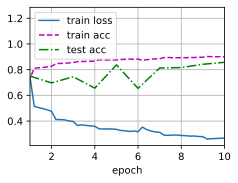

In [10]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

观察从第一个批量规范化层中学到的拉伸参数gamma和偏移参数beta。

In [11]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.4831, 4.2637, 3.6738, 2.1425, 0.6552, 3.2064], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([ 2.7032, -2.5674,  3.6447,  1.0282, -0.2783,  0.7502], device='cuda:0',
        grad_fn=<ViewBackward0>))

同时也可以直接使用框架中所定义的BatchNorm

In [12]:
net = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
        nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
        nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
        nn.Linear(84, 10))

loss 0.265, train acc 0.902, test acc 0.873
45064.6 examples/sec on cuda:0


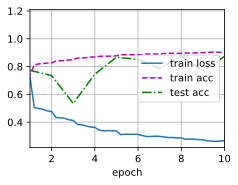

In [13]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 残差网络（ResNet）



残差网络（ResNet）是由 **Kaiming He** 等人在 2015 年提出的一种深度学习模型架构。它的核心思想是通过引入 **残差连接（Residual Connection）** 来解决深层网络中的梯度消失和网络退化问题，从而使得训练非常深的神经网络成为可能。ResNet 在图像分类、目标检测等任务中取得了显著的效果，并成为深度学习领域的里程碑之一。

---
## 1. **残差网络的背景**

### 1.1 **深层网络的问题**
- **梯度消失**：在非常深的神经网络中，梯度在反向传播过程中会逐渐变小，导致靠近输入层的参数几乎无法更新。
- **网络退化**：随着网络层数的增加，模型的性能不仅没有提升，反而可能下降。这种现象并不是由过拟合引起的，而是由于深层网络的优化难度增加。

### 1.2 **残差连接的提出**
- ResNet 通过引入 **残差连接**，使得网络可以学习输入与输出之间的残差（即差异），而不是直接学习输出。这种方式大大简化了深层网络的优化问题。

---

## 2. **残差网络的核心思想**

### 2.1 **残差块（Residual Block）**
残差网络的基本构建单元是 **残差块**。一个典型的残差块结构如下：

$$
y = F(x, \{W_i\}) + x
$$

其中：
- $x$ 是输入。
- $F(x, \{W_i\})$ 是残差函数，通常由若干卷积层、批量规范化层和激活函数组成。
- $y$ 是输出。

### 2.2 **残差连接的作用**
- 残差连接将输入 $x$ 直接加到残差函数 $F(x)$ 的输出上。
- 如果 $F(x)$ 的效果不好（例如梯度消失），网络可以通过将 $F(x)$ 学习为 0，从而退化为恒等映射 $y = x$。这种方式保证了深层网络的性能不会比浅层网络更差。

---

## 3. **残差网络的整体结构**

### 3.1 **ResNet 的层次结构**
ResNet 通常由多个残差块堆叠而成，分为以下几个部分：
1. **初始卷积层**：一个 7x7 的卷积层，用于提取低级特征。
2. **残差块堆叠**：多个残差块分为若干组，每组包含多个残差块。
3. **全局平均池化**：将特征图的空间维度降为 1x1。
4. **全连接层**：用于分类任务。

### 3.2 **ResNet 的变体**
ResNet 有多种变体，如 ResNet-18、ResNet-34、ResNet-50、ResNet-101 和 ResNet-152。它们的区别主要在于残差块的数量和结构：
- **ResNet-18/34**：使用基本的残差块（两个 3x3 卷积层）。
- **ResNet-50/101/152**：使用 **瓶颈残差块（Bottleneck Residual Block）**，包含 1x1、3x3 和 1x1 卷积层，以减少计算量。

---

## 4. **残差网络的优点**

### 4.1 **解决梯度消失问题**
- 残差连接使得梯度可以直接传播到浅层，避免了梯度消失问题。

### 4.2 **缓解网络退化问题**
- 即使深层网络的性能没有提升，残差连接也保证了网络不会比浅层网络更差。

### 4.3 **加速训练**
- 残差连接简化了优化问题，使得深层网络更容易训练。

### 4.4 **提高模型性能**
- ResNet 在 ImageNet 等数据集上取得了当时的最优性能，并成为后续许多模型的基础。

---

## 5. **残差网络的应用**

### 5.1 **图像分类**
- ResNet 在 ImageNet 图像分类任务中取得了显著的效果。

### 5.2 **目标检测**
- ResNet 被用作 Faster R-CNN、Mask R-CNN 等目标检测模型的主干网络。

### 5.3 **语义分割**
- ResNet 也被广泛应用于语义分割任务，如 FCN、U-Net 等。

---

## 6. **总结**

- **核心思想**：通过残差连接，使得网络可以学习输入与输出之间的残差，从而简化深层网络的优化问题。
- **主要优点**：
  1. 解决梯度消失和网络退化问题。
  2. 加速训练过程。
  3. 提高模型性能。
- **应用场景**：图像分类、目标检测、语义分割等计算机视觉任务。

残差网络的提出标志着深度学习模型设计的一个重要突破，它不仅使得训练非常深的神经网络成为可能，还为后续的模型设计提供了重要的启示。

In [14]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [15]:
class Residual(nn.Module):  # 定义一个残差块类
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        """
        初始化残差块。

        参数:
        - input_channels: 输入特征的通道数。
        - num_channels: 输出特征的通道数。
        - use_1x1conv: 是否使用1x1卷积调整输入的通道数和尺寸（默认为False）。
        - strides: 卷积的步幅（默认为1）。
        """
        super().__init__()
        
        # 第一个卷积层：3x3卷积，用于提取特征
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        
        # 第二个卷积层：3x3卷积，用于进一步提取特征
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        
        # 如果use_1x1conv为True，则使用1x1卷积调整输入的通道数和尺寸
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None  # 不使用1x1卷积
        
        # 批量规范化层，用于稳定训练过程
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        """
        前向传播函数。

        参数:
        - X: 输入特征，形状为 (batch_size, input_channels, height, width)。

        返回:
        - Y: 输出特征，形状为 (batch_size, num_channels, height', width')。
        """
        # 第一个卷积 + 批量规范化 + ReLU激活
        Y = F.relu(self.bn1(self.conv1(X)))
        
        # 第二个卷积 + 批量规范化
        Y = self.bn2(self.conv2(Y))
        
        # 如果使用1x1卷积，则对输入X进行调整
        if self.conv3:
            X = self.conv3(X)
        
        # 残差连接：将调整后的输入X加到Y上
        Y += X
        
        # 最后通过ReLU激活函数
        return F.relu(Y)

此代码生成两种类型的网络：一种是当use_1x1conv=False时，应用ReLU非线性函数之前，
将输入添加到输出。另一种是当use_1x1conv=True时，添加通过1 × 1卷积调整通道和分辨率

 下面我们来查看输入和输出形状一致的情况。

In [16]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

也可以在增加输出通道数的同时，减半输出的高和宽。

In [17]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

ResNet的前两层跟之前介绍的GoogLeNet中的一样：在输出通道数为64、步幅为2的7 × 7卷积层后，接步幅
为2的3 × 3的最大汇聚层。不同之处在于ResNet每个卷积层后增加了批量规范化层。

In [18]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet在后面接了4个由Inception块组成的模块。ResNet则使用4个由残差块组成的模块，每个模块使用
若干个同样输出通道数的残差块。第一个模块的通道数同输入通道数一致。由于之前已经使用了步幅为2的
最大汇聚层，所以无须减小高和宽。之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高
和宽减半。

In [19]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    """
    定义一个ResNet块，包含多个残差单元（Residual Units）。

    参数:
    - input_channels: 输入特征的通道数。
    - num_channels: 输出特征的通道数。
    - num_residuals: 该块中包含的残差单元的数量。
    - first_block: 是否是第一个ResNet块。如果是第一个块，则不需要进行下采样。

    返回:
    - blk: 一个包含多个残差单元的列表。
    """
    blk = []  # 初始化一个空列表，用于存储残差单元

    for i in range(num_residuals):  # 遍历残差单元的数量
        if i == 0 and not first_block:
            # 如果是第一个残差单元且不是第一个ResNet块，则需要进行下采样
            # 使用1x1卷积调整通道数，并且步幅为2进行下采样
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            # 其他情况，直接使用普通的残差单元，不进行下采样
            blk.append(Residual(num_channels, num_channels))

    return blk  # 返回包含残差单元的列表

In [20]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

最后，与GoogLeNet一样，在ResNet中加入全局平均汇聚层，以及全连接层输出。

In [21]:
net = nn.Sequential(b1, b2, b3, b4, b5,
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(), nn.Linear(512, 10))

每个模块有4个卷积层（不包括恒等映射的1 × 1卷积层）。加上第一个7 × 7卷积层和最后一个全连接层，共
有18层。因此，这种模型通常被称为ResNet‐18。通过配置不同的通道数和模块里的残差块数可以得到不同
的ResNet模型，例如更深的含152层的ResNet‐152。虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架
构更简单，修改也更方便。

在训练ResNet之前，让我们观察一下ResNet中不同模块的输入形状是如何变化的。在之前所有架构中，分辨
率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。

In [22]:
X = torch.rand(size=(1, 1, 224, 224))

for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.012, train acc 0.997, test acc 0.916
2375.3 examples/sec on cuda:0


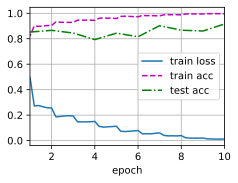

In [23]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 稠密连接网络

**稠密连接网络（DenseNet）** 是一种经典的深度学习模型，由 Gao Huang 等人在 2017 年提出。它的核心思想是通过 **密集连接（Dense Connection）** 来增强特征的重用和传播，从而提升模型的性能。DenseNet 在图像分类、目标检测等任务中表现出色，尤其是在参数效率和计算效率方面优于 ResNet 等模型。


## 1. **稠密连接的核心思想**
在传统的卷积神经网络（如 ResNet）中，每一层的输入仅来自前一层的输出。而在 DenseNet 中，每一层的输入来自前面所有层的输出。这种设计使得网络中的每一层都可以直接访问前面所有层的特征，从而增强了特征的传播和重用。

### 数学描述：
假设第 $l$ 层的输出为 $x_l$，则第 $l$ 层的输入是前面所有层输出的拼接（concatenation）：
$$
x_l = H_l([x_0, x_1, \dots, x_{l-1}])
$$
其中：
- $[x_0, x_1, \dots, x_{l-1}]$ 表示将前面所有层的输出在通道维度上拼接。
- $H_l$ 是第 $l$ 层的非线性变换（通常包括卷积、批归一化和激活函数）。

---

## 2. **稠密块（Dense Block）**
DenseNet 的基本组成单元是 **稠密块（Dense Block）**。一个稠密块由多个层组成，每一层都与前面所有层直接连接。稠密块的结构如下：
1. **输入**：稠密块的输入是前面所有层的输出拼接。
2. **非线性变换**：每一层通过一个非线性变换 $H_l$ 提取特征。
3. **输出**：每一层的输出会与前面所有层的输出拼接，作为下一层的输入。

稠密块的输出通道数会随着层数的增加而增长，因为每一层的输出都会拼接到后续层的输入中。

---

## 3. **过渡层（Transition Layer）**
由于稠密块的输出通道数会快速增长，为了控制模型的复杂度，DenseNet 引入了 **过渡层（Transition Layer）**。过渡层的作用是：
1. **降低通道数**：通过 1x1 卷积减少通道数。
2. **下采样**：通过 2x2 的平均池化层减少特征图的尺寸。

过渡层的结构通常为：
- 1x1 卷积：减少通道数。
- 2x2 平均池化：下采样。

---

## 4. **DenseNet 的整体结构**
DenseNet 的整体结构由多个 **稠密块** 和 **过渡层** 交替组成：
1. **初始卷积层**：对输入图像进行初步特征提取。
2. **稠密块 + 过渡层**：多个稠密块和过渡层交替堆叠，逐步提取高层次特征。
3. **全局平均池化**：将特征图的空间维度降为 1x1。
4. **全连接层**：输出分类结果。

---

## 5. **DenseNet 的优势**
1. **特征重用**：
   - 由于每一层都可以访问前面所有层的特征，DenseNet 能够更好地重用特征，减少冗余计算。

2. **参数效率**：
   - DenseNet 的参数数量比 ResNet 等模型更少，因为每一层只需要提取少量的新特征。

3. **缓解梯度消失**：
   - 稠密连接使得梯度可以直接传播到前面的层，缓解了深层网络中的梯度消失问题。

4. **更强的特征表达能力**：
   - 通过拼接前面所有层的特征，DenseNet 能够捕捉到更丰富的特征表示。

---

## 6. **DenseNet 的数学特性**
假设一个稠密块有 $L$ 层，每层的输出通道数为 $k$（称为增长率，growth rate），则：
- 稠密块的输入通道数为 $C_0$。
- 第 $l$ 层的输入通道数为 $C_0 + k \times (l-1)$。
- 稠密块的输出通道数为 $C_0 + k \times L$。

这种设计使得 DenseNet 的特征通道数随着层数的增加而线性增长，而不是指数增长。

---

## 7. **DenseNet 的变体**
DenseNet 有多种变体，主要区别在于 **增长率 $k$** 和 **网络深度**：
- **DenseNet-121**：增长率 $k=32$，网络深度为 121 层。
- **DenseNet-169**：增长率 $k=32$，网络深度为 169 层。
- **DenseNet-201**：增长率 $k=32$，网络深度为 201 层。

---

## 8. **DenseNet 的应用**
DenseNet 在以下任务中表现出色：
1. **图像分类**：在 CIFAR、ImageNet 等数据集上取得了优异的分类精度。
2. **目标检测**：作为特征提取器，用于 Faster R-CNN 等检测模型。
3. **语义分割**：用于提取多尺度特征，提升分割精度。



In [24]:
import torch
from torch import nn
from d2l import torch as d2l

In [25]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

一个稠密块由多个卷积块组成，每个卷积块使用相同数量的输出通道。然而，在前向传播中，我们将每个卷
积块的输入和输出在通道维上连结。

In [26]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        """
        初始化稠密块（Dense Block）。

        参数:
        - num_convs: 稠密块中卷积层的数量。
        - input_channels: 输入特征的通道数。
        - num_channels: 每个卷积层输出的通道数（也称为增长率，growth rate）。
        """
        super(DenseBlock, self).__init__()
        layer = []  # 初始化一个空列表，用于存储卷积层
        for i in range(num_convs):
            # 每个卷积层的输入通道数为：input_channels + i * num_channels
            # 这是因为每一层的输入是前面所有层输出的拼接
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        
        # 将所有的卷积层组合成一个序列
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        """
        前向传播函数。

        参数:
        - X: 输入特征，形状为 (batch_size, input_channels, height, width)。

        返回:
        - X: 输出特征，形状为 (batch_size, input_channels + num_convs * num_channels, height, width)。
        """
        for blk in self.net:
            Y = blk(X)  # 对输入X进行卷积操作
            # 将当前卷积层的输出Y与输入X在通道维度上拼接
            X = torch.cat((X, Y), dim=1)
        
        return X  # 返回拼接后的特征

我们定义一个有2个输出通道数为10的DenseBlock。使用通道数为3的输入时，我们会得到
通道数为3 + 2 × 10 = 23的输出。卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称
为增长率（growth rate）。


In [27]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。而过渡层可以用来控制模型复杂度。
它通过1 × 1卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。

In [28]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

对上一个例子中稠密块的输出使用通道数为10的过渡层。此时输出的通道数减为10，高和宽均减半。

In [29]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

现在开始构造DenseNet模型。DenseNet首先使用同ResNet一样的单卷积层和最大汇聚层。

In [30]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

类似于ResNet使用的4个残差块，DenseNet使用的是4个稠密块。与ResNet类似，我们可以设置每个稠密块使用多少个卷积层。这里我们设成4，从而与ResNet‐18保持一致。稠密块里的卷积层通道数（即增长率）设为32，所以每个稠密块将增加128个通道。

在每个模块之间，ResNet通过步幅为2的残差块减小高和宽，DenseNet则使用过渡层来减半高和宽，并减半通道数。

In [31]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32  # 初始化当前通道数为64，增长率为32

# 定义每个稠密块中卷积层的数量
num_convs_in_dense_blocks = [4, 4, 4, 4]

# 初始化一个空列表，用于存储稠密块和过渡层
blks = []

# 遍历num_convs_in_dense_blocks，构建稠密块和过渡层
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    # 添加一个稠密块
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    
    # 更新当前通道数：上一个稠密块的输出通道数
    # 稠密块的输出通道数 = 输入通道数 + 卷积层数量 * 增长率
    num_channels += num_convs * growth_rate
    
    # 在稠密块之间添加一个过渡层（除了最后一个稠密块）
    if i != len(num_convs_in_dense_blocks) - 1:
        # 过渡层的作用是将通道数减半
        blks.append(transition_block(num_channels, num_channels // 2))
        
        # 更新当前通道数为过渡层输出通道数
        num_channels = num_channels // 2

与ResNet类似，最后接上全局汇聚层和全连接层来输出结果

In [32]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

由于这里使用了比较深的网络，这里将输入高和宽从224降到96来简化计算。

loss 0.142, train acc 0.948, test acc 0.814
2391.6 examples/sec on cuda:0


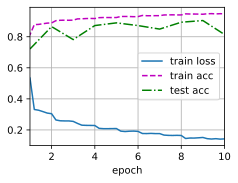

In [34]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())